In [99]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

import matplotlib
import numpy as np
matplotlib.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams["font.size"] = 24
matplotlib.rcParams["lines.linewidth"] = 4
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5, linewidth=4, edgecolor='black')
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolyzed Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data



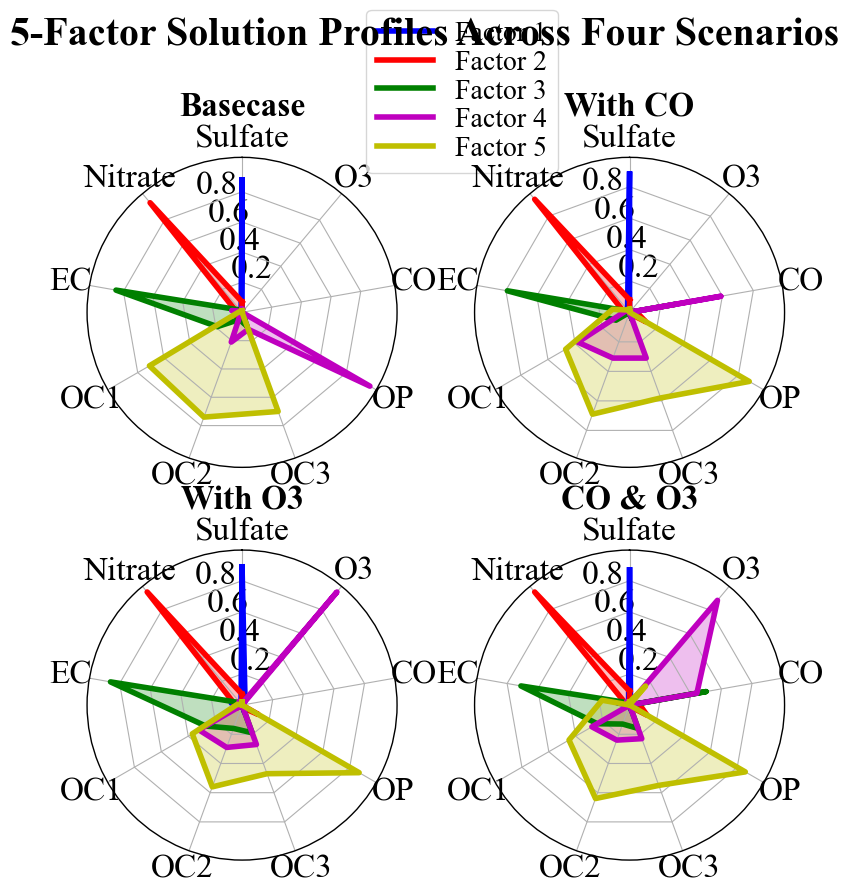

In [100]:
N = 9
theta = radar_factory(N, frame='circle')

data = example_data()
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                            labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
            horizontalalignment='center', color='black', weight='bold',
            size='large')

plt.show()

In [18]:
title, data1 = data[0]

In [41]:
len(data1)
data1[0]

[0.88, 0.01, 0.03, 0.03, 0.0, 0.06, 0.01, 0.0, 0.0]

Text(0.77, 0.03, 'gender')

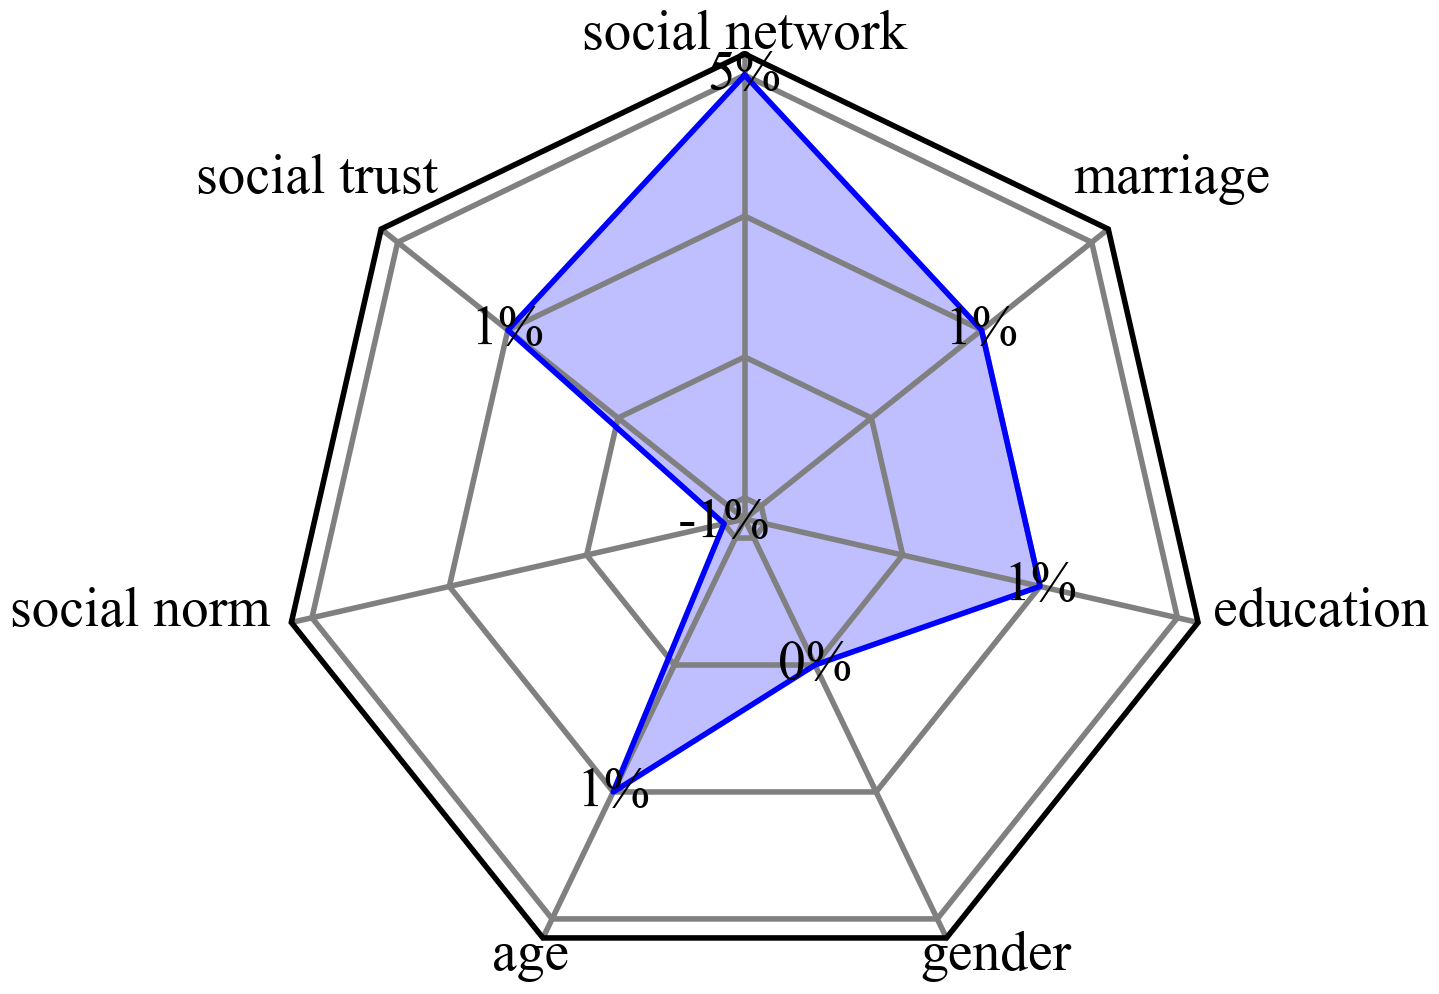

In [114]:
import numpy as np
N = 7
# title = "influence factor for happiness"
data = [[2, 1, -1, 1, 0, 1, 1]]
spoke_labels = ["social network", "social trust", "social norm", "age", "gender", "education", "marriage"]
theta = radar_factory(N, frame='polygon')
fig, ax = plt.subplots(figsize=(12, 12),subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
colors = ['b', 'r']#['b', 'r', 'g', 'm', 'y']
ax.set_rgrids([-3, -2, -1, 0, 1, 2, 3], labels=[], fmt=None)
ax.grid(color='gray', linestyle='-', linewidth=4)
# ax.set_rgrids([], [])
# # ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1), horizontalalignment='center', verticalalignment='center')
for d, color in zip(data, colors):
    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_') #='_nolegend_'
    for theta_val, d_val in zip(theta, d):
        if abs(d_val) > 1:
            val = np.sign(d_val) *(abs(d_val) - 1) *5
        else:
            val = d_val
        ax.annotate(f"{val}%", xy=(theta_val, d_val), textcoords='data',size=40,ha="center", va="center", zorder=10)
ax.set_varlabels([])
ax.spines['polar'].set_linewidth(4)
ax.text(0.5, 1.02, "social network", transform=ax.transAxes, ha='center', va='center', fontdict={'size':40})
ax.text(0.04, 0.865, "social trust", transform=ax.transAxes, ha='center', va='center', fontdict={'size':40})
ax.text(0.96, 0.865, "marriage", transform=ax.transAxes, ha='center', va='center', fontdict={'size':40})
ax.text(-0.15, 0.4, "social norm", transform=ax.transAxes, ha='center', va='center', fontdict={'size':40})
ax.text(1.12, 0.4, "education", transform=ax.transAxes, ha='center', va='center', fontdict={'size':40})
ax.text(0.27, 0.03, "age", transform=ax.transAxes, ha='center', va='center', fontdict={'size':40})
ax.text(0.77, 0.03, "gender", transform=ax.transAxes, ha='center', va='center', fontdict={'size':40})


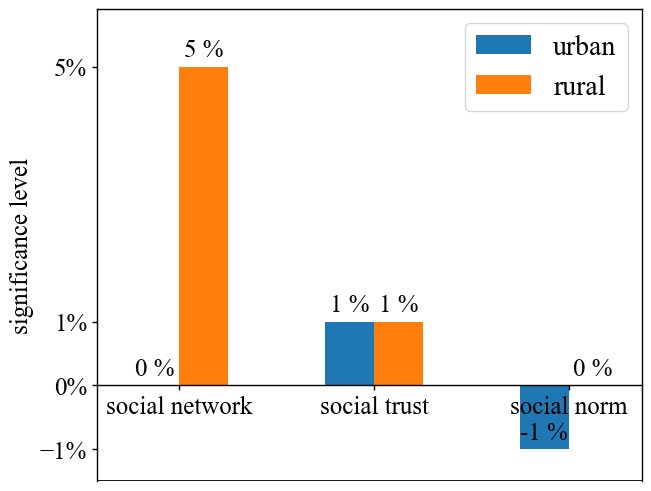

<Figure size 640x480 with 0 Axes>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams["font.size"] = 22
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams['axes.linewidth'] = 1 
species = ("social network", "social trust", "social norm")
penguin_means = {
    'urban': (0, 0.01, -0.01),
    'rural': (0.05, 0.01, 0),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=0, fmt='%.2f%%')
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height*100:.0f} %', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=18)  # Calculate and display the percentage value
    multiplier += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species, fontsize=18)
ax.legend(loc='upper right', fontsize=20)
xmin, xmax = ax.get_xlim()
ax.spines['bottom'].set_position('zero')
ax.set_xlim(xmin=xmin-0.05,xmax=xmax)
ax.set_ylim(bottom=-0.015, top=0.059)
ax.set_ylabel('significance level', fontdict={'size':18, 'family': "Times New Roman"})
ax.hlines(y=-0.015, color='black', xmin=xmin-0.05, xmax=xmax)
ax.tick_params(axis='both', labelsize=18, width=1)

# Set y-axis ticks and labels
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
ax.tick_params(axis='y', labelsize=18)
yticks = [-0.01, 0, 0.01, 0.05]
ax.set_yticks(yticks)

# ax.set_yticks([])
plt.show()
plt.tight_layout()

In [2]:
gdp_annual = np.array([7.8, 7, 6.8, 6.9, 6.7, 6, 2.2, 8.4, 3])
happen_idx = np.array([4.98, 5.14, 5.25, 5.27, 5.25, 5.19, 5.34, 5.59, 5.82])
x = np.arange(2013, 2023)
x = np.delete(x, 1)
x

array([2013, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [20]:
k = [ str(xx) for xx in x]
k

['2013', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17112\2372884500.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x, rotation = -45)


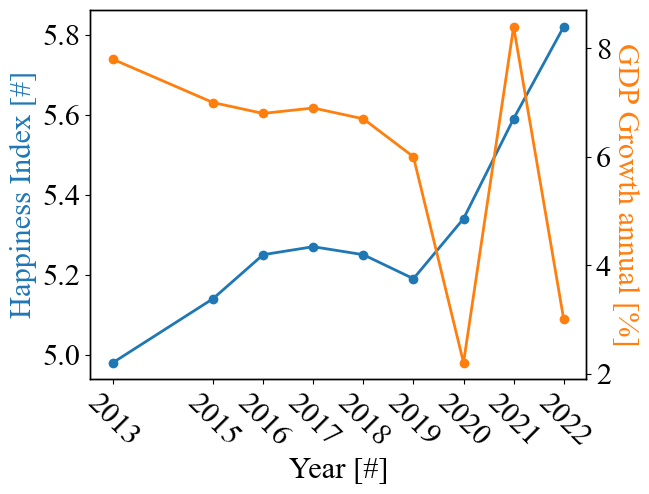

In [59]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, happen_idx, '-o', color = '#1f77b4')
# for i, txt in enumerate(happen_idx):
#     ax1.annotate(txt, (x[i], happen_idx[i]),  fontsize =18)
ax2.plot(x, gdp_annual, '-o', color='#ff7f0e')
# for i, txt in enumerate(gdp_annual):
#     ax2.annotate(txt, (x[i], gdp_annual[i]), fontsize =18)
ax1.set_xlabel('Year [#]')
ax1.set_ylabel('Happiness Index [#]', color='#1f77b4')
ax2.set_ylabel('GDP Growth annual [%]', color='#ff7f0e', rotation=-90, labelpad=20)
# ax1.set_xlim(right=2023)
# ax1.set_ylim(top=6.1)
ax1.set_xticklabels(x, rotation = -45)

plt.xticks(x)
# plt.xticks(rotation=45)
plt.show()

In [ ]:
variable	mean value	standard deviation
Sne	4.092 	1.76
Str	3.680 	0.933
Sno	2.254 	1.128
Health	3.709 	0.929
Happiness	4.056 	0.722


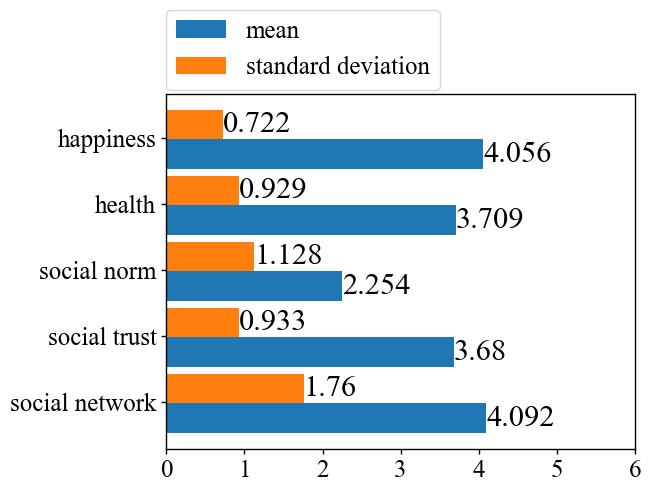

<Figure size 640x480 with 0 Axes>

In [97]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams["font.size"] = 22
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams['axes.linewidth'] = 1 
species = ('social network', "social trust", "social norm", "health", "happiness")
penguin_means = {
    'mean': (4.092, 3.680, 2.254, 3.709, 4.056),
    'standard deviation': (1.76, 0.933, 1.128, 0.929, 0.722),
    
}

x = np.arange(len(species))  # the label locations
width = 0.45  # the width of the bars
multiplier = 0.45

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=0)

    multiplier += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_yticks(x + width, species, fontsize=18)
ax.legend(loc='upper right', fontsize=18, bbox_to_anchor=(0.61, 1.27))
ax.tick_params(axis='both', labelsize=18, width=1)
# ax.tick_params(axis='y', rotation=45)
_, xmax = ax.get_xlim()
ax.set_xlim(xmax=6)

# ax.set_yticks([])
plt.show()
plt.tight_layout()